# Anomaly Detection Challenge 2
## Miguel Sandim and Paula Fortuna

## 0 - Library Imports & Utils

In [1]:
# pandas
import pandas as pd
from pandas import Series,DataFrame

# numpy, matplotlib, seaborn
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# Random libraries and seeds:
import random
random.seed(2)
np.random.seed(2)

pd.set_option('display.max_columns', None)

In [2]:
# From: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
import itertools
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

######################################
# Function Save Data To CSV
######################################

def saveDataToCSV(Y_pred):
    id_list = range(0, len(Y_pred))
    submission = pd.DataFrame({
        "Id": id_list,
        "Expected": Y_pred
    })
    submission = submission[['Id', 'Expected']]
    submission.to_csv('submission.csv', index=False)
    return


# 1 - Data Reading

### 1.1 - Solve format problems

#### 1.1.1 -  yelp_data_train.dat and yelp_data_test.dat

In a text editor (e. g. sublime) use regex.

1) Replace " by ""

2) Surround text field with "
To match the first one use this (dont forget to remove the one that appears also in the begining of the sentence, and the one in the header):

^[^;]*;[^;]*;[^;]*;

Use this to find the last:

;[^;]*;[^;]*;[^;]*;[^;]*;[^;]*;[^;]*$ 

3) check if all the lines match the refered structure:

^[^;]*

4) Remove random newlines that appear in the rows and make new instance

#### 1.1.2 - yelp_data_reviewer.dat

1) ; caracter removed from fields

2) smiles removed from fields

#### 1.3 hotel file

1) removal of ; in the link

### 1.2 Load data (finally!)

In [3]:
# read from csv

train_df = pd.read_csv("data/yelp_data_train.dat", sep = ';', encoding = 'utf-8')
test_df = pd.read_csv("data/yelp_data_test.dat", sep = ';', encoding = 'utf-8')
reviewers_df = pd.read_csv("data/yelp_data_reviewer.dat", sep = ';', encoding = 'utf-8')
hotels_df = pd.read_csv("data/yelp_data_hotel.dat", sep = ';', encoding = 'utf-8')

In [4]:
train_df["fake"].value_counts()

N    2516
Y     392
Name: fake, dtype: int64

In [5]:
392/(392 + 2516)

0.13480055020632736

## About 13% of our dataset are anomalous cases. We also checked that each reviewer only reviewed each hotel once, at maximum.

# 2 - Data Pre-Processing

In [6]:
import sklearn.preprocessing as skpre

## 2.1 - Solve Missing Values

In [7]:
train_df.set_value(2550, 'reviewContent', ' ')

,date,reviewID,reviewerID,reviewContent,rating,usefulCount,coolCount,funnyCount,fake,hotelID
0,9/16/2010,Ol,nf3q2h-kSQoZK2jBY92FOg,"If you are considering staying here, watch thi...",1,8,2,6,N,tQfLGoolUMu2J0igcWcoZg
1,2/5/2010,i4HIAcNTjabdpG1K4F5Q2g,Sb3DJGdZ4Rq__CqxPbae-g,"This place is disgusting, absolutely horrible,...",3,11,4,9,N,tQfLGoolUMu2J0igcWcoZg
2,8/9/2010,veKKNAaSKWj8os,nR7zLyFOlzAYqmzgJ3DtXg,Disgusting!!! There is literally duct tape ho...,1,1,0,3,N,tQfLGoolUMu2J0igcWcoZg
3,8/11/2012,6c-ZiQkHXtp1n6VfiKDQ3g,747lP4p8dUD6RTkcsIaSGg,This hotel came up on Hotwire for $108 a night...,4,2,0,1,N,33Xc1Bk_gkSY5xb2doQ7Ng
4,7/9/2012,POWQ6FuUf3oe2ZkhmHvciA,Ij5t6VdwtasSkrpp9uAbKg,"Good location, really run down. I am surprised...",2,0,0,0,N,33Xc1Bk_gkSY5xb2doQ7Ng
5,6/19/2012,QBynYcLgIgtAd-YfnrrAtA,hSERzClUe57bCw3nCp4plA,Beautiful lobby. The rest is a dump. The eleva...,1,0,1,1,N,33Xc1Bk_gkSY5xb2doQ7Ng
6,9/14/2012,ELY3TK,OMm2VcGks3QL0p0n3_kPFw,Stayed here when I went to Chicago for a weddi...,3,2,0,0,N,33Xc1Bk_gkSY5xb2doQ7Ng
7,3/20/2012,uWKWYb5vDpeDGEAZUc192g,yevHGEUQQmnVlBXIrJ885A,I bleed SPG loyalty blood to the point where I...,1,1,1,0,N,33Xc1Bk_gkSY5xb2doQ7Ng
8,3/3/2012,hkt7Dnr7kRnLLd9pm-fxDw,Lql1_3zeGlny_Tgq4MI6Fg,"I stayed here a couple of times in 2011, as th...",3,0,0,0,N,33Xc1Bk_gkSY5xb2doQ7Ng
9,6/18/2012,ZlexD7XvkqH8yve4zCAR7g,RtyDimVdIBwjGdQr0dti1w,"This is an older property, so the decor is dat...",1,0,0,0,N,33Xc1Bk_gkSY5xb2doQ7Ng


## 2.2 - Feature Extraction

### 2.2.1 - Features from paper

In [8]:
train_df.shape

(2908, 10)

In [9]:
def maxNumberOfReviews(data):
    import datetime
    date_old = [datetime.datetime.strptime(x, "%B %Y") for x in data["yelpJoinDate"]]
    date_new = datetime.datetime.strptime("October 2012", "%B %Y") # Data da review mais antiga
    data["reviewsPerDay"] = data["reviewCount"] / [(date_new - x).days for x in date_old]
    
maxNumberOfReviews(reviewers_df)

In [10]:
def PPR():
    
    percentageReviews = []
    
    for r_id in reviewers_df["reviewerID"]:
        train_count = (train_df["reviewerID"] == r_id).sum()
        test_count = (test_df["reviewerID"] == r_id).sum()
        
        
        train_count_4 = train_df.loc[(train_df["reviewerID"] == r_id) & (train_df["rating"] > 4)].shape[0]
        test_count_4 = test_df.loc[(test_df["reviewerID"] == r_id) & (test_df["rating"] > 4)].shape[0]
        
        if ((train_count + test_count) == 0):
            percentageReviews.append(0.0)
        else:
            percentageReviews.append((train_count_4 + test_count_4) / (train_count + test_count))

    reviewers_df["percentageReviews"] = percentageReviews

        
    # para cada reviewer fazer get do ID,
        # Contar o nº de vezes que o ID aparece no train + test com >= 4
        # meter no revewer
        
PPR()

In [11]:
# Adapted from http://stackoverflow.com/questions/15173225/how-to-calculate-cosine-similarity-given-2-sentence-strings-python
def cosSim(text1, text2):
    import re, math
    from collections import Counter

    WORD = re.compile(r'\w+')

    def get_cosine(vec1, vec2):
        intersection = set(vec1.keys()) & set(vec2.keys())
        numerator = sum([vec1[x] * vec2[x] for x in intersection])

        sum1 = sum([vec1[x]**2 for x in vec1.keys()])
        sum2 = sum([vec2[x]**2 for x in vec2.keys()])
        denominator = math.sqrt(sum1) * math.sqrt(sum2)

        if not denominator:
            return(0.0)
        else:
            return(numerator / denominator)

    def text_to_vector(text):
        words = WORD.findall(text)
        return Counter(words)

    vector1 = text_to_vector(text1)
    vector2 = text_to_vector(text2)

    cosine = get_cosine(vector1, vector2)
    return(cosine)
    
def similarityUsers():
    import itertools as it
    
    mean_distance = []
    
    for r_id in reviewers_df["reviewerID"]:
        texts_train = train_df[train_df["reviewerID"] == r_id]["reviewContent"]
        texts_test = test_df[test_df["reviewerID"] == r_id]["reviewContent"]
        texts = np.append(texts_train, texts_test)
        
        #print("tamanho do texto %d" % len(texts))
        if (len(texts) == 0 or len(texts) == 1):
            mean_distance.append(0.0)
        else:
            # Get all combinations of reviews from an user:
            combs = list(it.combinations(texts,2))
            #print(len(texts))
            #print(len(combs))
            dist_list = [cosSim(comb[0], comb[1]) for comb in list(it.combinations(texts,2))]
            #print(dist_list)

            # Calculate the mean distance for the user's reviews
            mean_distance.append(np.mean(np.array(dist_list)))
        
    reviewers_df["reviewSimilarity"] = mean_distance 
    # percorrer os users
        # buscar todos os textos do user (indices)
            # ver a função das combinações e pedir a cosSim para todos, no fim fazer a media
similarityUsers()  

In [12]:
def markFakeUsers():
    import itertools as it
    
    fakeUser = []
    
    for r_id in reviewers_df["reviewerID"]:
        fake_train = train_df[train_df["reviewerID"] == r_id]["fake"]
        
        if (len(fake_train) == 0):
            fakeUser.append(0)
        else:
            # check if any of the fake is 'Y'
            if ('Y' in fake_train.values):
                fakeUser.append(1)
            else:
                fakeUser.append(0)
        
    reviewers_df["fakeUser"] = fakeUser 
    # percorrer os users
        # buscar todos os textos do user (indices)
            # ver a função das combinações e pedir a cosSim para todos, no fim fazer a media
markFakeUsers()  

### Joining tables

In [13]:
train_df_joined = train_df.add_suffix("_review").join(reviewers_df.add_suffix("_user")).join(hotels_df.add_suffix("_hotel")).drop([
        "reviewerID_review",
        "hotelID_review"
    ], axis=1)

test_df_joined = test_df.add_suffix("_review").join(reviewers_df.add_suffix("_user")).join(hotels_df.add_suffix("_hotel")).drop([
        "reviewerID_review",
        "hotelID_review"
    ], axis=1)

In [14]:
train_df_joined.columns

Index(['date_review', 'reviewID_review', 'reviewContent_review',
       'rating_review', 'usefulCount_review', 'coolCount_review',
       'funnyCount_review', 'fake_review', 'reviewerID_user', 'name_user',
       'location_user', 'yelpJoinDate_user', 'friendCount_user',
       'reviewCount_user', 'firstCount_user', 'usefulCount_user',
       'coolCount_user', 'funnyCount_user', 'complimentCount_user',
       'tipCount_user', 'fanCount_user', 'reviewsPerDay_user',
       'percentageReviews_user', 'reviewSimilarity_user', 'fakeUser_user',
       'hotelID_hotel', 'name_hotel', 'location_hotel', 'reviewCount_hotel',
       'rating_hotel', 'categories_hotel', 'address_hotel',
       'AcceptsCreditCards_hotel', 'PriceRange_hotel', 'WiFi_hotel',
       'webSite_hotel', 'phoneNumber_hotel', 'filReviewCount_hotel'],
      dtype='object')

In [15]:
#train_df_joined

In [16]:
#test_df_joined

In [17]:
train_df_joined.to_csv("train_joined.csv", encoding='utf-8')

### 2.1.2 - Text Mining

In [18]:
def lengthReview(data):
    data['text_length'] = data['reviewContent_review'].str.len() 
    data['word_count'] = data['reviewContent_review'].str.count(' ')
    
lengthReview(train_df_joined)
lengthReview(test_df_joined)

In [19]:
# bag of words based in the words referenced in the paper
def bagOfWords(data): 
    personal_pronouns = ['i', 'we', 'me', 'us', 'my', 'mine', 'our', 'ours']
    associated_actions = ['went', 'feel']
    targets = ['area', 'options', 'price', 'stay']
    emotion_words = ['nice', 'deal', 'comfort', 'helpful']

    import collections, re

    # put in lower case
    data['reviewContent_review'] = data['reviewContent_review'].str.lower()
    
    # Replace characters
    data['reviewContent_review'] = data['reviewContent_review'].str.replace('\xa0',' ')
    
    texts = list(data['reviewContent_review'])
    bagsofwords = [collections.Counter(re.findall(r'\w+', txt)) 
                   for txt in texts]

    def count_words(data, word_list, attribute_name):
        data[attribute_name] = np.nan
        for i in range(0, data.shape[0]):
            num = 0
            for word in word_list:
                num += bagsofwords[i][word]
                
            if (data["word_count"][i] == 0):
                data.set_value(i, attribute_name, 0.0)
            else:
                data.set_value(i, attribute_name, num/data["word_count"][i])

    count_words(data, personal_pronouns, 'count_pronouns')
    count_words(data, associated_actions, 'count_associated_actions')
    count_words(data, targets, 'count_targets')
    count_words(data, emotion_words, 'count_emotion_words')
    
bagOfWords(train_df_joined)
bagOfWords(test_df_joined)

### 2.1.2. - Other features

In [20]:
def deviationFromHotelRating(data):
    data["deviatonReviewHotel"] = data["rating_review"] - data["rating_hotel"]

deviationFromHotelRating(train_df_joined)
deviationFromHotelRating(test_df_joined)

In [21]:
def countsUserReview(data):
    data["popularity_review"] = data["usefulCount_review"] + data["coolCount_review"] + data["funnyCount_review"]
        
    data["popularity_user"] = data["usefulCount_user"] + data["coolCount_user"] + data["funnyCount_user"] + data["complimentCount_user"] + data["fanCount_user"]

countsUserReview(train_df_joined)
countsUserReview(test_df_joined)

In [22]:
#train_df_joined

In [23]:
#test_df_joined

## 2.4 Sampling

### 2.4.1 Undersampling

In [24]:
def undersampling(data):
    ids_to_sample = data[data["fake_review"] == "N"].index.values
    sample_size = data[data["fake_review"] == "Y"].shape[0]
    anomalies = data[data["fake_review"] == "Y"].index.values
    
    final_ids = np.append(np.random.choice(ids_to_sample, size = sample_size), anomalies)
    #print(ids_to_sample)
    #data[fake_review]
    return data.iloc[final_ids]
    
train_df_joined = undersampling(train_df_joined)  

### 2.4.2 Oversampling

In [25]:
def oversampling(data):
    anomalies = data[data["fake_review"] == "Y"]
    data = data.append(anomalies)
    data = data.append(anomalies)
    data = data.append(anomalies)
    data = data.append(anomalies)
    data = data.append(anomalies)
    data = data.append(anomalies)
    return data

#train_df_joined = oversampling(train_df_joined)  

## 2.5 Define global variables for the model

In [27]:
def encodeVariables():
    
    target_variable = "fake_review" # target variable
    
    dropVariableList = [
        
        ###all list of variables, then choose the ones to keep
        
        #REVIEW FEATURES
        
        
        
        'date_review', #not useful
        'reviewID_review', #not useful
        'reviewContent_review', #not useful after having the features
        #'rating_review', 
        #'usefulCount_review', #correlated 1
        #'coolCount_review',  #correlated 1
        #'funnyCount_review', #correlated 1
        'popularity_review', # feature computed with the counts
        
        #USER FEATURES
        
        'reviewerID_user', #not useful
        'name_user', #not useful
        'location_user', #not useful
        'yelpJoinDate_user', #not useful
        #'friendCount_user', #mean proves it distinguish among the groups, #based on feature selection
        #'reviewCount_user', #mean proves it distinguish among the groups
        #'firstCount_user', # very strange patern in the mean values
        #'usefulCount_user', # correlated 2
        #'coolCount_user', # correlated 2
        #'funnyCount_user', # correlated 2
        #'complimentCount_user', # correlated 2
        #'tipCount_user', # very strange patern in the mean values
        #'fanCount_user', # correlated 2
        #'reviewsPerDay_user', 
        #'percentageReviews_user', #based on feature selection
        #'reviewSimilarity_user', #based on feature selection
        'popularity_user', # feature computed with the counts // based on feature selection
        
        #HOTEL FEATURES
        
        'hotelID_hotel', #not useful
        'name_hotel',  #not useful
        'location_hotel', #not useful
        #'reviewCount_hotel',# correlated 3
        #'rating_hotel', # correlated 4
        'categories_hotel', #not useful
        'address_hotel', #not useful
        #'AcceptsCreditCards_hotel', #not useful
        #'PriceRange_hotel', #not useful 
        #'WiFi_hotel', #not useful
        'webSite_hotel', #not useful
        'phoneNumber_hotel',#not useful
        #'filReviewCount_hotel', #based on feature selection
        #'deviatonReviewHotel',
        
        #TEXT MINING FEATURES
        #'text_length',
        #'word_count', #based on feature selection
        #'count_pronouns', #based on feature selection
        #'count_associated_actions',#based on feature selection
        #'count_targets', #based on feature selection
        #'count_emotion_words', #based on feature selection
        
        #EXTRA FEATURES
        #'fakeUser_user'
        
        ]
 
    # Drop variables in the X
    X_train = train_df_joined.drop(dropVariableList, axis=1)
    
    X_train.to_csv("X_train.csv", index = False, encoding='utf-8') # Save this in a CSV before dropping target
    
    X_train = X_train.drop(target_variable, axis=1)
    X_test = test_df_joined.drop(dropVariableList, axis=1)
    X_test = X_test.drop("id_review", axis=1)
    
    # Drop variables in the Y
    Y_train = train_df_joined["fake_review"]

    # Transform categorical variables for X_train:
    categoricalVariableList = [
        "AcceptsCreditCards_hotel",
        "PriceRange_hotel",
        "WiFi_hotel"
    ]
    
    for var_name in categoricalVariableList:
        encoder = skpre.LabelEncoder().fit(X_train[var_name].append(X_test[var_name]))
        X_train[var_name] = encoder.transform(X_train[var_name])
        X_test[var_name] = encoder.transform(X_test[var_name])

    # Transform categorical variables for Y_train
    Y_train = skpre.LabelEncoder().fit_transform(Y_train)

    print(X_train)
    #print(X_test)
    print(Y_train)
    
    return X_train, Y_train, X_test

train_df_joined = train_df_joined.iloc[np.random.permutation(len(train_df_joined))]

X_train, Y_train, X_test = encodeVariables()

      rating_review  usefulCount_review  coolCount_review  funnyCount_review  \
2672              5                   0                 0                  0   
170               1                   0                 0                  0   
933               5                   0                 0                  0   
2357              2                   0                 0                  0   
2894              1                   0                 0                  0   
2840              4                   0                 0                  0   
1753              5                   1                 1                  0   
2553              5                   0                 0                  0   
2552              5                   0                 0                  0   
2272              5                   0                 0                  0   
2526              1                   0                 0                  0   
2813              5                   0 

In [28]:
X_train

,rating_review,usefulCount_review,coolCount_review,funnyCount_review,friendCount_user,reviewCount_user,firstCount_user,usefulCount_user,coolCount_user,funnyCount_user,complimentCount_user,tipCount_user,fanCount_user,reviewsPerDay_user,percentageReviews_user,reviewSimilarity_user,fakeUser_user,reviewCount_hotel,rating_hotel,AcceptsCreditCards_hotel,PriceRange_hotel,WiFi_hotel,filReviewCount_hotel,text_length,word_count,count_pronouns,count_associated_actions,count_targets,count_emotion_words,deviatonReviewHotel
2672,5,0,0,0,29,237,31,227,109,447,40,0,10,0.090527,0.000000,0.000000,0,95,3.5,2,0,1,0,575,95,0.000000,0.000000,0.000000,0.010526,1.5
170,1,0,0,0,33,12,0,2,1,1,1,9,1,0.017143,0.000000,0.000000,0,178,3.0,2,1,2,0,559,103,0.116505,0.000000,0.019417,0.000000,-2.0
933,5,0,0,0,0,20,0,4,2,7,0,0,1,0.025253,1.000000,0.000000,1,223,3.5,2,3,1,0,503,94,0.063830,0.000000,0.000000,0.000000,1.5
2357,2,0,0,0,12,501,4,182,75,42,22,0,1,0.238571,0.000000,0.000000,0,78,4.5,1,4,2,0,534,106,0.047170,0.009434,0.000000,0.000000,-2.5
2894,1,0,0,0,51,385,20,391,234,139,83,0,3,0.200625,0.000000,0.000000,0,33,3.0,2,0,1,0,777,137,0.080292,0.000000,0.007299,0.000000,-2.0
2840,4,0,0,0,0,9,0,0,0,0,0,0,0,0.015517,0.000000,0.000000,0,96,4.0,2,1,0,0,344,62,0.048387,0.000000,0.000000,0.000000,0.0
1753,5,1,1,0,40,137,14,178,96,30,44,0,5,0.263969,1.000000,0.000000,0,7,2.5,1,4,2,0,2089,400,0.092500,0.000000,0.007500,0.000000,2.5
2553,5,0,0,0,117,275,48,486,287,216,570,47,8,0.170384,0.000000,0.000000,0,11,2.5,2,0,1,0,606,110,0.045455,0.000000,0.027273,0.009091,2.5
2552,5,0,0,0,44,194,15,205,105,59,45,1,6,0.099538,0.000000,0.000000,0,26,4.0,2,1,1,0,1005,177,0.056497,0.000000,0.005650,0.000000,1.0
2272,5,0,0,0,43,142,8,175,112,68,49,9,2,0.244828,0.000000,0.000000,0,124,4.5,1,4,2,0,1478,277,0.079422,0.000000,0.003610,0.000000,0.5


In [29]:
X_train.columns

Index(['rating_review', 'usefulCount_review', 'coolCount_review',
       'funnyCount_review', 'friendCount_user', 'reviewCount_user',
       'firstCount_user', 'usefulCount_user', 'coolCount_user',
       'funnyCount_user', 'complimentCount_user', 'tipCount_user',
       'fanCount_user', 'reviewsPerDay_user', 'percentageReviews_user',
       'reviewSimilarity_user', 'fakeUser_user', 'reviewCount_hotel',
       'rating_hotel', 'AcceptsCreditCards_hotel', 'PriceRange_hotel',
       'WiFi_hotel', 'filReviewCount_hotel', 'text_length', 'word_count',
       'count_pronouns', 'count_associated_actions', 'count_targets',
       'count_emotion_words', 'deviatonReviewHotel'],
      dtype='object')

In [30]:
len(X_train.columns)

30

In [31]:
sum(Y_train)

392

In [32]:
len(Y_train)

784

### Normalize features

In [ ]:
def featureNormalization():
    global X_train
    global X_test
    
    scaler = skpre.StandardScaler().fit(X_train)
    X_train = scaler.transform(X_train)
    X_test = scaler.transform(X_test)
    
#featureNormalization()

In [ ]:
X_train

## 3.1 - Model selection based on which models do best in CV using default settings:

In [33]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier().fit(X_train, Y_train)

In [34]:
rf.feature_importances_

array([ 0.02744583,  0.15915509,  0.08051205,  0.04447052,  0.04513294,
        0.04927782,  0.02358031,  0.03260846,  0.04214492,  0.03326136,
        0.02448847,  0.02473819,  0.01179376,  0.04341354,  0.0080685 ,
        0.01392277,  0.00560562,  0.04049034,  0.02264503,  0.00721319,
        0.01633885,  0.01084221,  0.00328429,  0.03949145,  0.03993958,
        0.0446234 ,  0.0149503 ,  0.02259267,  0.02316186,  0.04480668])

In [35]:
fe_v = [ 0.02744583,  0.15915509,  0.08051205,  0.04447052,  0.04513294,
        0.04927782,  0.02358031,  0.03260846,  0.04214492,  0.03326136,
        0.02448847,  0.02473819,  0.01179376,  0.04341354,  0.0080685 ,
        0.01392277,  0.00560562,  0.04049034,  0.02264503,  0.00721319,
        0.01633885,  0.01084221,  0.00328429,  0.03949145,  0.03993958,
        0.0446234 ,  0.0149503 ,  0.02259267,  0.02316186,  0.04480668]

fe_n = ['rating_review', 'usefulCount_review', 'coolCount_review',
       'funnyCount_review', 'friendCount_user', 'reviewCount_user',
       'firstCount_user', 'usefulCount_user', 'coolCount_user',
       'funnyCount_user', 'complimentCount_user', 'tipCount_user',
       'fanCount_user', 'reviewsPerDay_user', 'percentageReviews_user',
       'reviewSimilarity_user', 'fakeUser_user', 'reviewCount_hotel',
       'rating_hotel', 'AcceptsCreditCards_hotel', 'PriceRange_hotel',
       'WiFi_hotel', 'filReviewCount_hotel', 'text_length', 'word_count',
       'count_pronouns', 'count_associated_actions', 'count_targets',
       'count_emotion_words', 'deviatonReviewHotel']

features = []
for i in range(0, len(fe_v)):
    features.append((fe_v[i], fe_n[i]))
    
features.sort(key = lambda x: x[0], reverse = True)
features

[(0.15915509, 'usefulCount_review'),
 (0.08051205, 'coolCount_review'),
 (0.04927782, 'reviewCount_user'),
 (0.04513294, 'friendCount_user'),
 (0.04480668, 'deviatonReviewHotel'),
 (0.0446234, 'count_pronouns'),
 (0.04447052, 'funnyCount_review'),
 (0.04341354, 'reviewsPerDay_user'),
 (0.04214492, 'coolCount_user'),
 (0.04049034, 'reviewCount_hotel'),
 (0.03993958, 'word_count'),
 (0.03949145, 'text_length'),
 (0.03326136, 'funnyCount_user'),
 (0.03260846, 'usefulCount_user'),
 (0.02744583, 'rating_review'),
 (0.02473819, 'tipCount_user'),
 (0.02448847, 'complimentCount_user'),
 (0.02358031, 'firstCount_user'),
 (0.02316186, 'count_emotion_words'),
 (0.02264503, 'rating_hotel'),
 (0.02259267, 'count_targets'),
 (0.01633885, 'PriceRange_hotel'),
 (0.0149503, 'count_associated_actions'),
 (0.01392277, 'reviewSimilarity_user'),
 (0.01179376, 'fanCount_user'),
 (0.01084221, 'WiFi_hotel'),
 (0.0080685, 'percentageReviews_user'),
 (0.00721319, 'AcceptsCreditCards_hotel'),
 (0.00560562, 'fake

LR: 0.830400 (0.029092)
LDA: 0.746304 (0.065945)


C:\Users\migsa\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\migsa\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\migsa\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\migsa\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\migsa\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\migsa\Anaconda3\lib\site-packages\sklearn\discriminant_analysis.py:387: UserWarning: Variables are collinear.
  warnings.warn("Variables are collinear.")
C:\Users\migsa\Anacond

KNN: 0.552763 (0.051457)
CART: 0.732179 (0.035318)
NB: 0.820357 (0.035276)
SVM-RBF: 0.586855 (0.049228)
NN: 0.603568 (0.066174)
RF: 0.841397 (0.047244)
AB: 0.840564 (0.025373)
XGB: 0.850332 (0.022986)


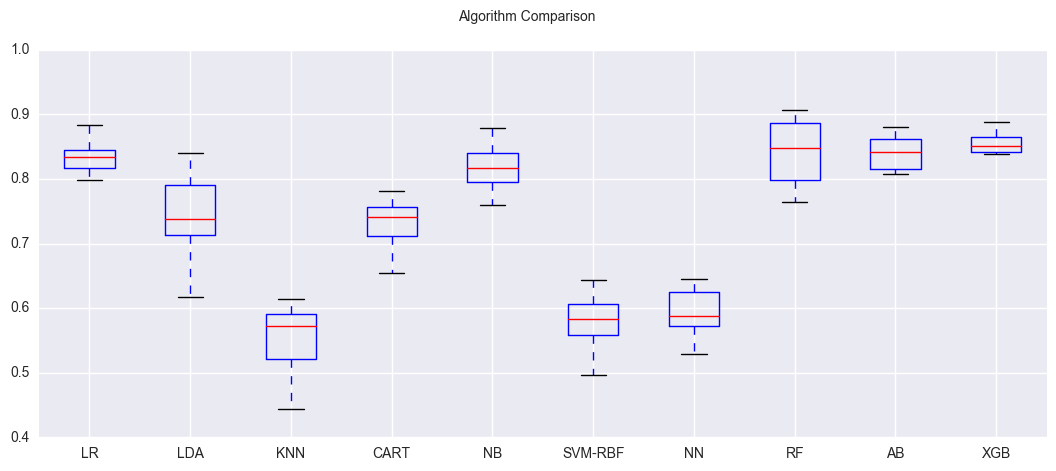

In [36]:
#inspired in http://machinelearningmastery.com/compare-machine-learning-algorithms-python-scikit-learn/

import sklearn.model_selection as mds
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
import xgboost as xgb

def modelSelection():

    # prepare data

    #Y_train = train_df[:,-1]
    #X_train = train_df[:,:-1]

    #Y_train = train_df[len(train_df.columns)-1]
    #X_train = train_df.drop(len(train_df.columns)-1,axis=1)

    # prepare configuration for cross validation test harness
    num_folds = 10
    num_instances = len(X_train)

    # prepare models
    models = []
    models.append(('LR', LogisticRegression()))
    models.append(('LDA', LinearDiscriminantAnalysis()))
    models.append(('KNN', KNeighborsClassifier()))
    models.append(('CART', DecisionTreeClassifier()))
    models.append(('NB', GaussianNB()))
    #models.append(('SVM-Linear', SVC(kernel="linear")))
    #models.append(('SVM-Poly', SVC(kernel="poly")))
    models.append(('SVM-RBF', SVC(kernel="rbf")))
    models.append(('NN', MLPClassifier())) 
    models.append(('RF', RandomForestClassifier()))
    models.append(('AB', AdaBoostClassifier()))
    models.append(('XGB', xgb.XGBClassifier()))

    # evaluate each model in turn
    results = []
    scoring = 'roc_auc' # try with 'roc_auc', f1'

    kfold = mds.StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=2)

    for model_name, model in models:
        cv_results = mds.cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
        results.append({"name": model_name, "cv_results": cv_results, "mean": cv_results.mean(), "std": cv_results.std()})
        print("%s: %f (%f)" % (model_name, cv_results.mean(), cv_results.std()))

    # boxplot algorithm comparison
    fig = plt.figure(figsize=(13, 5), dpi=500)
    fig.suptitle('Algorithm Comparison')
    ax = fig.add_subplot(111)
    plt.boxplot([x["cv_results"] for x in results])
    ax.set_xticklabels([x["name"] for x in results])
    plt.show()

    # order the models by the mean auc
    #results_by_strategy.sort(key=lambda x: x["mean"], reverse=True)
    #print([(x["name"], x["mean"]) for x in results])

modelSelection()

### Tuning Random Forests

In [51]:
from sklearn.model_selection import GridSearchCV

def tuneRandomForests():
    
    grid = {
        "n_estimators": np.arange(10, 700, 20),
        "criterion": ["gini", "entropy"],
        "max_features": ["auto", "sqrt", "log2", None]
    }
    
    gsearch = GridSearchCV(estimator = RandomForestClassifier(), 
                            param_grid = grid, scoring='roc_auc', cv=10, n_jobs=5)
    
    result = gsearch.fit(X_train, Y_train)
    return result

tunningrf = tuneRandomForests()

In [52]:
tunningrf.cv_results_

{'mean_fit_time': array([  0.05634549,   0.18438158,   0.29385886,   0.37821889,
          0.61783938,   0.78235693,   0.94397144,   1.15547171,
          1.29367058,   1.34675815,   1.94358246,   2.57613242,
          1.95243881,   2.07387507,   2.33010752,   2.21232347,
          3.07298605,   2.49317338,   2.60926802,   2.77142158,
          2.88625293,   3.0402626 ,   3.18811774,   3.29444361,
          3.4819268 ,   3.60846694,   3.8069582 ,   4.27283959,
          4.09681401,   4.23666363,   4.42870035,   4.50325346,
          4.6721235 ,   4.85090067,   5.04678998,   0.08405948,
          0.22375903,   0.37986965,   0.51086328,   0.65256393,
          0.81843185,   0.94652319,   1.12995396,   1.23352742,
          1.40254755,   1.55130329,   1.6495234 ,   1.82609873,
          1.97120209,   2.11055117,   2.25000019,   2.41872048,
          2.58023531,   2.69947057,   2.87919822,   3.466716  ,
          3.7221977 ,   3.76778021,   3.42998989,   3.57659407,
          3.74186175,  

In [53]:
tunningrf.best_params_

{'criterion': 'entropy', 'max_features': 'log2', 'n_estimators': 630}

In [54]:
tunningrf.best_score_

0.85554765175300906

# 4 - Submission to Kaggle

In [37]:
# choose algorithm
def makeSubmissionKaggle(algorithm):
    algorithm.fit(X_train, Y_train)
    Y_pred = algorithm.predict(X_test)
    Y_pred = Y_pred.astype(int)

    # save data to CSV
    saveDataToCSV(Y_pred)
    
#makeSubmissionKaggle("07-spec-mean", xgb.XGBClassifier( learning_rate=0.01, n_estimators=5000, max_depth=7,
#                      min_child_weight=1, gamma=0, subsample=0.55, colsample_bytree=0.85,
#                      reg_alpha=1e-5, objective= 'binary:logistic', scale_pos_weight=1, seed=2))

#makeSubmissionKaggle("09-spec-min", LinearDiscriminantAnalysis(n_components = 1, shrinkage = "auto", solver="lsqr"))
#makeSubmissionKaggle(RandomForestClassifier(criterion = 'entropy', max_features = 'log2', n_estimators = 630))
makeSubmissionKaggle(RandomForestClassifier(criterion = 'entropy', max_features = 'log2', n_estimators = 630))